In [35]:
import pandas as pd
import seaborn as sns
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from tqdm import tqdm_notebook as tqdm
# import cv2

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from os.path import isfile, join

# from glob import glob
import os
import re
from PIL import Image
import pydicom

sns.set()

import pydicom

from os import listdir

# from skimage.transform import resize
# from imgaug import augmenters as iaa

# from keras.utils import Sequence

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import HTML

In [20]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
traindf = pd.read_csv(INPUT_PATH + "stage_2_train.csv")
traindf.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [21]:
label = traindf.Label.values

In [22]:
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
# df.rename({'0': 'ImageID', '1': 'ID'}, axis=1, inplace=True)
traindf.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [23]:
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / traindf.groupby("subtype").size() * 100

In [24]:
traindf

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0
...,...,...,...
4516837,ID_4a85a3a3f,intraparenchymal,0
4516838,ID_4a85a3a3f,intraventricular,0
4516839,ID_4a85a3a3f,subarachnoid,0
4516840,ID_4a85a3a3f,subdural,0


In [25]:
train_images_dir = INPUT_PATH + 'stage_2_train/'
test_images_dir = INPUT_PATH + 'stage_2_test/'

train = pd.read_csv(INPUT_PATH + 'stage_2_train.csv')
test = pd.read_csv(INPUT_PATH + 'stage_2_sample_submission.csv')

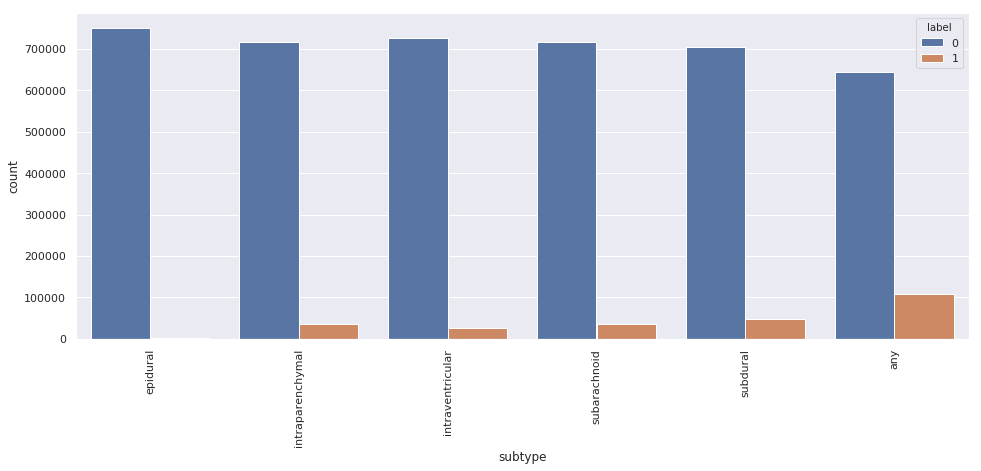

In [26]:
plt.figure(figsize=(16, 6))
graph = sns.countplot(x="subtype", hue="label", data=(traindf))
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
plt.show()

In [27]:
train_images_dir = INPUT_PATH + 'stage_2_train/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images_dir = INPUT_PATH + 'stage_2_test/'
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
print('5 Training images', train_images[:5]) 

5 Training images ['ID_e1b0c40f8.dcm', 'ID_fd7075095.dcm', 'ID_0efbbad9a.dcm', 'ID_76087830a.dcm', 'ID_7f78ff9fd.dcm']


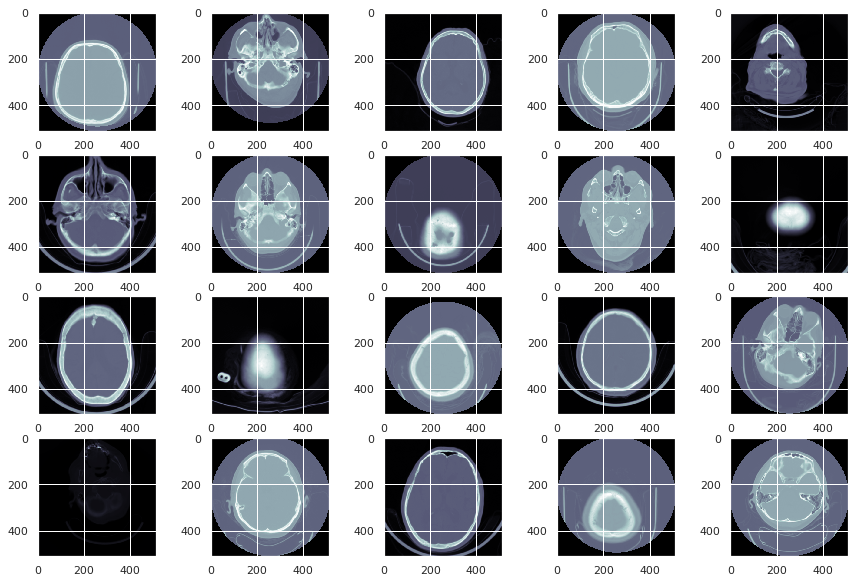

In [28]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [40]:
dicom = pydicom.read_file(train_images_dir + 'ID_e1b0c40f8.dcm')
print(dicom)

NameError: name 'path_train_img' is not defined

In [29]:
train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head(10)


Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
5,ID_0000aee4b,0,0,0,0,0,0
6,ID_0000ca2f6,0,0,0,0,0,0
7,ID_0000f1657,0,0,0,0,0,0
8,ID_000178e76,0,0,0,0,0,0
9,ID_00019828f,0,0,0,0,0,0


In [33]:
def _get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def _get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [_get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def get_image(data, windowing=None):
    window_center, window_width, intercept, slope = windowing or _get_windowing(data)
    img = data.pixel_array
    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img

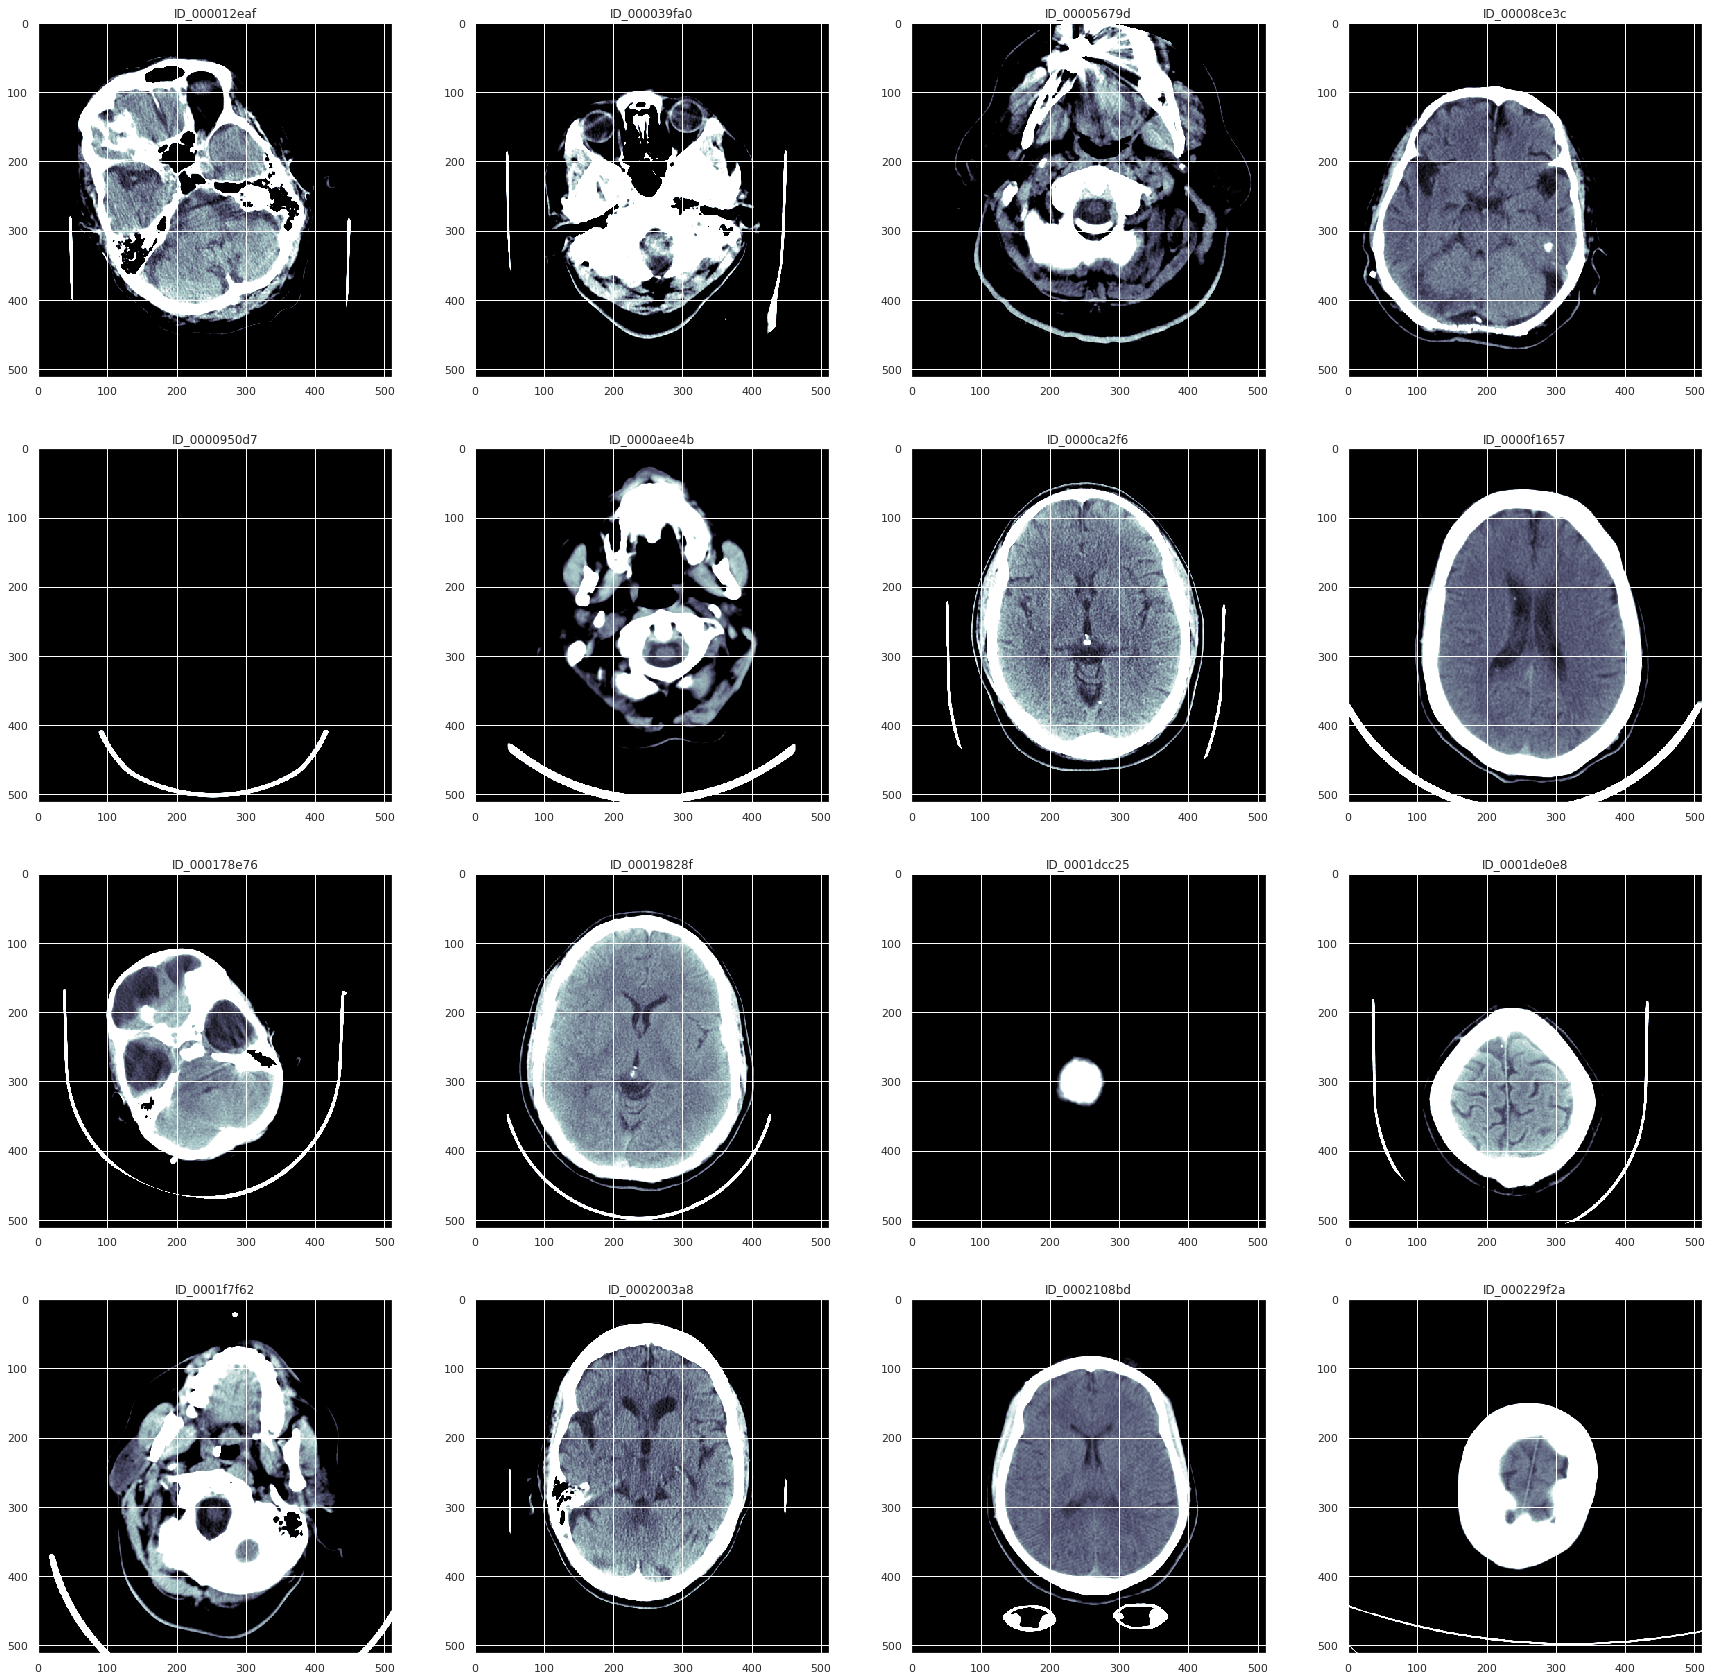

In [34]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30,30))

for i in range(16):
    idx = train[train['any'] == 0]['Image'].iloc[i]
    data = pydicom.dcmread(train_images_dir + idx + '.dcm')
    img = get_image(data)
    ax[i//4, i%4].set_title(idx)
    ax[i//4, i%4].imshow(img, cmap=plt.cm.bone)

In [36]:
for n in range(6):
    multiple = train[train[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) == n].copy()
    print('Number of hemorrhages: {}, amount of such images: {}, fraction: {:.3f}%'.format(n, len(multiple), 100 * len(multiple) / len(train)))

Number of hemorrhages: 0, amount of such images: 644870, fraction: 85.663%
Number of hemorrhages: 1, amount of such images: 75859, fraction: 10.077%
Number of hemorrhages: 2, amount of such images: 24826, fraction: 3.298%
Number of hemorrhages: 3, amount of such images: 6217, fraction: 0.826%
Number of hemorrhages: 4, amount of such images: 1008, fraction: 0.134%
Number of hemorrhages: 5, amount of such images: 23, fraction: 0.003%


Most images (85%) show normal brains.  
10% of images have only one type of hemorrhage.  
There are **23[](http://) samples** having all the hemorrhage types at the same time

In [37]:
len(multiple)

23

In [38]:
multiple['Patient ID'] = multiple['Image'].map(lambda image: pydicom.dcmread(train_images_dir + image + '.dcm')[('0010', '0020')].repval.replace("'", ''))
multiple

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,Patient ID
34388,ID_0bac24ce5,1,1,1,1,1,1,ID_91c7e0f8
48264,ID_105ddbd5a,1,1,1,1,1,1,ID_fc4fcd34
90056,ID_1e969aca4,1,1,1,1,1,1,ID_39d7d875
107235,ID_24740ebaf,1,1,1,1,1,1,ID_4e643f54
124408,ID_2a42ed30a,1,1,1,1,1,1,ID_4e643f54
194235,ID_41fe9ca79,1,1,1,1,1,1,ID_cdd0b8d7
207556,ID_46887c63e,1,1,1,1,1,1,ID_cdd0b8d7
258562,ID_57c30b661,1,1,1,1,1,1,ID_b2f8ff72
294636,ID_63eb7a3ff,1,1,1,1,1,1,ID_91c7e0f8
371001,ID_7deac4997,1,1,1,1,1,1,ID_221f7159


In [39]:
multiple['Patient ID'].unique()

array(['ID_91c7e0f8', 'ID_fc4fcd34', 'ID_39d7d875', 'ID_4e643f54',
       'ID_cdd0b8d7', 'ID_b2f8ff72', 'ID_221f7159', 'ID_4bb9b55c',
       'ID_9e89a2a1'], dtype=object)